In [1]:
### TODO implement rectified flow: https://arxiv.org/pdf/2209.03003

In [46]:
def torch2np(im):
    print('type im', type(im))
    if len(im.shape) == 4:
        return im.detach().permute(0, 2, 3, 1).cpu().numpy()
    if len(im.shape) == 3:
        return im.detach().permute(1, 2, 0).cpu().numpy()
    if len(im.shape) == 1:
        return im.detach().cpu().numpy()
    else:
        inspect('im', im)
        raise Exception

def show_tensor(x, max_n_horiz=9, height=75):
    """ Expect x.shape = (B, C, H, W) or (C, H, W) """
    if isinstance(x, torch.Tensor):
        x = torch2np(x)
    if len(x.shape) == 4:
        if max_n_horiz is None:           
            media.show_images(x, border=True, height=height)
        else:
            B = x.shape[0]
            idx = 0
            while idx < B:
                media.show_images(x[idx:idx+max_n_horiz], height=height)
                idx += max_n_horiz
    else:
        media.show_image(x, height=height)

## Setup environment

In [1]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
import mediapy as media
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
## some util functions that I find useful.

def inspect(label, im):
    """ Print some basic image stats."""
    if im is None:
      return
    print()
    print(label + ':')
    print('shape:', im.shape)
    print('dtype:', im.dtype)
    print('max:', torch.max(im))
    print('min:', torch.min(im))
    if im.dtype == torch.float32:
      print('mean:', torch.mean(im))
      print('std:', torch.std(im))
    print()


def ctime_as_fname():
    """ Return time.ctime() formatted well for a file name."""
    return  time.ctime().replace(' ', '_').replace(':', '.')

In [4]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

mps


In [5]:
train_set = MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor(),
)

print(train_set)

x, y = train_set[0]
inspect('x', x)
media.show_image(x.squeeze(0), height=150)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

x:
shape: torch.Size([1, 28, 28])
dtype: torch.float32
max: tensor(1.)
min: tensor(0.)
mean: tensor(0.1377)
std: tensor(0.3125)



In [6]:
""" nn.Modules """

class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation=nn.GELU):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activation = activation()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.conv(x)
      x = self.bn(x)
      x = self.activation(x)
      return x


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation=nn.GELU):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activation = activation()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation=nn.GELU):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activation = activation()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class Flatten(nn.Module):
    def __init__(self, activation=nn.GELU):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=7)
        self.activation = activation()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(x)
        x = self.activation(x)
        return x


class Unflatten(nn.Module):
    def __init__(self, in_channels: int, activation=nn.GELU):
        super().__init__()
        self.in_channels = in_channels
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=7,
            stride=7,
            padding=0,
        )
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activation = activation()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # inspect('unflatten.forward initial x:', x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation=nn.GELU):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = Conv(in_channels=in_channels, out_channels=out_channels, activation=activation)
        self.conv2 = Conv(in_channels=out_channels, out_channels=out_channels, activation=activation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = x + self.conv2(x)
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation=nn.GELU):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = Conv(in_channels=in_channels, out_channels=out_channels, activation=activation)
        self.conv2 = DownConv(in_channels=out_channels, out_channels=out_channels, activation=activation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation=nn.GELU):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = Conv(in_channels=in_channels, out_channels=out_channels, activation=activation)
        self.conv2 = UpConv(in_channels=out_channels, out_channels=out_channels, activation=activation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation=nn.GELU):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_channels, out_features=out_channels)
        self.activation = activation()
        self.fc2 = nn.Linear(in_features=out_channels, out_features=out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int = 64,
        activation=nn.GELU,
    ):
        super().__init__()
        D = num_hiddens
        self.D = D
        self.cb1 = ConvBlock(in_channels=1, out_channels=D, activation=activation)
        self.db1 = DownBlock(in_channels=D, out_channels=D, activation=activation)
        self.db2 = DownBlock(in_channels=D, out_channels=2*D, activation=activation)
        self.flatten = Flatten(activation=activation)
        self.unflatten = Unflatten(in_channels=2*D, activation=activation)
        self.ub2 = UpBlock(in_channels=4*D, out_channels=D, activation=activation)
        self.ub1 = UpBlock(in_channels=2*D, out_channels=D, activation=activation)
        self.cb2 = ConvBlock(in_channels=2*D, out_channels=D, activation=activation)
        # self.conv_out = Conv(in_channels=D, out_channels=1, activation=activation) ## this line is wrong, line below is correct (think: we dont want to apply an activation to the model outputs, we would like the model to be able to predict arbitrary outputs, not just outpures > -.5 or whatever min_x GELU(x) is)
        self.conv_out = nn.Conv2d(in_channels=D, out_channels=1, kernel_size=3, stride=1, padding=1)

        ## add the time conditional layers
        self.fc_unflat_t = FCBlock(in_channels=1, out_channels=2*D, activation=activation)
        self.fc_ub2_t = FCBlock(in_channels=1, out_channels=D, activation=activation)


    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        # inspect('x', x)
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        N, C, H, W = x.shape

        unflat_t = self.fc_unflat_t(t).reshape(N, 2*self.D, 1, 1)
        ub2_t = self.fc_ub2_t(t).reshape(N, self.D, 1, 1)

        x0 = self.cb1(x)
        x1 = self.db1(x0)
        x2 = self.db2(x1)
        flat = self.flatten(x2)
        lat2 = self.unflatten(flat)
        lat2 = lat2 + unflat_t
        lat2 = torch.concat((x2, lat2), dim=1)
        lat1 = self.ub2(lat2)
        lat1 = lat1 + ub2_t
        lat1 = torch.concat((x1, lat1), dim=1)
        lat0 = self.ub1(lat1)
        lat0 = torch.concat((x0, lat0), dim=1)
        lat0 = self.cb2(lat0)
        out = self.conv_out(lat0)
        return out

In [174]:
### DDPM ###


def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas = torch.linspace(beta1, beta2, num_ts).reshape(num_ts, 1, 1, 1).to(torch.float32).to(device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return {
        "betas": betas.to(device),
        "alphas": alphas.to(device),
        "alpha_bars": alpha_bars.to(device),
    }
    

def tc_ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
    verbose: bool = False,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    N, C, H, W = x_0.shape
    t = torch.randint(low=0, high=num_ts, size=(N,), device=device)

    noise = torch.randn_like(x_0, device=device)
    ab = ddpm_schedule['alpha_bars']
    x_t = (
        torch.sqrt(ab[t]) * x_0
        + torch.sqrt(1 - ab[t]) * noise
    )
    t = t.unsqueeze(-1).to(torch.float32) / num_ts  ## note t.unsqueeze(-1) for the FCBlocks
    noise_pred = unet(x=x_t, t=t)
    loss = F.mse_loss(noise, noise_pred)
    return loss


@torch.inference_mode()
def tc_ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
    num_samples: int = 1,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    torch.manual_seed(seed)
    N, C, H, W = num_samples, 1, img_wh[0], img_wh[1]
    x_t = torch.randn(N, C, H, W).to(device)
    traj = [x_t]
    for t_scalar in torch.arange(num_ts - 1, 0, -1).to(device):
        torch.manual_seed(seed)
        if t_scalar > 1:
            z = torch.randn_like(x_t).to(device)
        else:
            z = torch.zeros_like(x_t).to(device)
        t = torch.ones(N, dtype=int).to(device) * t_scalar

        noise_pred = unet(x=x_t, t=t.unsqueeze(-1).to(torch.float32)/num_ts)

        a = ddpm_schedule['alphas'].to(device)
        ab = ddpm_schedule['alpha_bars'].to(device)
        b = ddpm_schedule['betas'].to(device)

        clean_est = (x_t - torch.sqrt(1 - ab[t]) * noise_pred) / torch.sqrt(ab[t])

        a0 = torch.sqrt(ab[t-1]) * b[t]
        a1 = torch.sqrt(a[t]) * (1 - ab[t-1])
        x_t = (a0 * clean_est + a1 * x_t) / (1 - ab[t])
        x_t = x_t + torch.sqrt(b[t]) * z
        traj.append(x_t)

        seed += 1
    return x_t, torch.cat(traj, dim=1)


class TCDDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in self.ddpm_schedule.items():
            self.register_buffer(k, v, persistent=False)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return tc_ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
        num_samples: int = 1,
    ):
        return tc_ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed, num_samples=num_samples
        )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:14<00:00,  6.29it/s]


Epoch [1/3], Loss: 0.0957


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:14<00:00,  6.27it/s]


Epoch [2/3], Loss: 0.0621


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:14<00:00,  6.27it/s]


Epoch [3/3], Loss: 0.0564


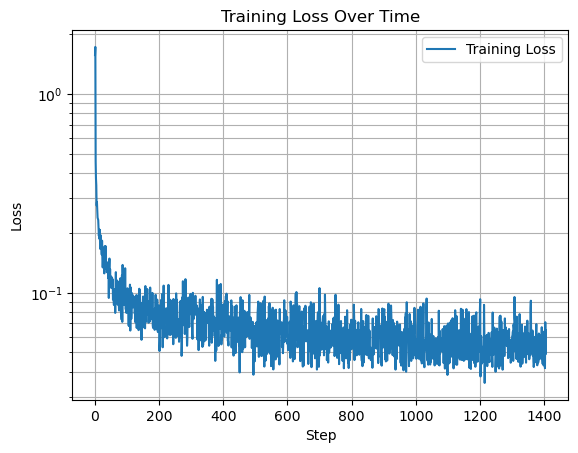

In [198]:
""" Create TimeConditionalUNet DDPM model and train it, or load weights from saved checkpoint. """

num_epochs = 3
num_hiddens = 64
batch_size = 128

load_from_saved = False
epoch_number_str = '2'
checkpoint_fname_stem = f'data/tcond_unet_optim_epoch' # {epoch_number_str}.pth'
checkpoint_fname = f'{checkpoint_fname_stem}{epoch_number_str}.pth'

model = TimeConditionalUNet(
    in_channels=1,
    num_hiddens=num_hiddens,
).to(device)

ddpm = TCDDPM(
    unet=model,
    betas=(1e-4, 0.2),
    num_ts=30,
).to(device)

gamma = 0.1 ** (1.0 / num_epochs)

subset = torch.utils.data.Subset(train_set, list(range(1_000)))

dataloader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
)

optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

cur_epoch = 0
tcond_ddpm_train_losses = []

if load_from_saved:

    checkpoint = torch.load(checkpoint_fname, weights_only=True)
    cur_epoch = checkpoint['epoch'] + 1
    tcond_ddpm_train_losses = checkpoint['train_losses']
    ddpm.load_state_dict(checkpoint['ddpm_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

for epoch in range(cur_epoch, num_epochs):
    epoch_loss = 0
    batch_count = 0
    for x, y in tqdm(dataloader):
        optimizer.zero_grad() ## .. i initially forgot this line and ended up with train curves that have a distincly oscillitory (underdamped) motion.. interesting..
        x = x.to(device)
        # x = x*2 - 1 ### affine scaling
        loss = ddpm(x)
        loss.backward()
        optimizer.step()
        tcond_ddpm_train_losses.append(loss.item())
        epoch_loss += loss.item()
        # batch_count += 1
        # if batch_count > 100:
        #     break
    average_loss = epoch_loss / len(dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

    lr_scheduler.step()

    if (epoch % 5 == 0) or (epoch == num_epochs - 1):
        checkpoint = {
            'epoch': epoch,
            'ddpm_state_dict': ddpm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'train_losses': tcond_ddpm_train_losses,
        }
        path = f'{checkpoint_fname_stem}{epoch}.pth'
        # path = f'/content/drive/My Drive/cs180_project5/tcond_unet_optim_epoch{epoch}.pth'
        if not os.path.exists('data'):
            os.mkdir('data')

        torch.save(checkpoint, path)


%matplotlib inline
plt.plot(tcond_ddpm_train_losses, label='Training Loss')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid('true', which='both')
plt.title('Training Loss Over Time')
plt.legend()
# plt.savefig('/content/drive/My Drive/cs180_project5/tcond_ddpm_train_curve.png')
plt.show()

In [199]:
x_0, traj = ddpm.sample(img_wh=(28, 28), seed=11, num_samples=32)
inspect('x0', x_0)
show_tensor(torch.clip(x_0, 0, 1).cpu(), max_n_horiz=8, height=75)


x0:
shape: torch.Size([32, 1, 28, 28])
dtype: torch.float32
max: tensor(1.2587, device='mps:0')
min: tensor(-0.3323, device='mps:0')
mean: tensor(0.1273, device='mps:0')
std: tensor(0.3031, device='mps:0')

type im <class 'torch.Tensor'>


In [200]:
### load time conditional ddpm from checkpoint. create sample generation figures and animation

epoch_number_str = '2'
checkpoint_fname = f'data/tcond_unet_optim_epoch{epoch_number_str}.pth'

model = TimeConditionalUNet(
    in_channels=1,
    num_hiddens=num_hiddens,
).to(device)

ddpm = TCDDPM(
    unet=model,
    betas=(1e-4, 0.02),
    num_ts=200,
).to(device)

checkpoint = torch.load(checkpoint_fname, weights_only=True)
ddpm.load_state_dict(checkpoint['ddpm_state_dict'])

n_samples = 32

x_0, traj = ddpm.sample(img_wh=(28, 28), seed=11, num_samples=n_samples)
inspect('x0', x_0)
inspect('traj', traj)
show_tensor(torch.clip(x_0, 0, 1).cpu(), max_n_horiz=8, height=75)


N, T, H, W = traj.shape
nrows = 4
assert (N % nrows) == 0, 'N must be divisible by nrows'
ncols = N // nrows
trj = (torch.clip(traj, 0, 1) * 255).byte().cpu().numpy()
# trj = trj.transpose(1, 2, 0, 3).reshape(T, H, -1)
trj = trj.reshape(nrows, ncols, T, H, W).transpose(2, 0, 3, 1, 4).reshape(T, nrows * H, ncols * W)

frames = [frame for frame in trj]

media.show_video(frames, height=200, fps=150)
# media.write_video(f'/content/drive/My Drive/cs180_project5/tcond_ddpm_sample_trajectories_epoch{epoch_number_str}.mp4', frames)


x0:
shape: torch.Size([32, 1, 28, 28])
dtype: torch.float32
max: tensor(1.2359, device='mps:0')
min: tensor(-0.2402, device='mps:0')
mean: tensor(0.0807, device='mps:0')
std: tensor(0.2421, device='mps:0')


traj:
shape: torch.Size([32, 200, 28, 28])
dtype: torch.float32
max: tensor(4.2155, device='mps:0')
min: tensor(-4.3976, device='mps:0')
mean: tensor(0.0579, device='mps:0')
std: tensor(0.7183, device='mps:0')

type im <class 'torch.Tensor'>


In [238]:
### Rectified Flow ###


def tc_rf_forward(
    unet: TimeConditionalUNet,
    x: torch.Tensor,
) -> torch.Tensor:
    """
    Args:
        unet: TimeConditionalUNet
        x: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    N, C, H, W = x.shape
    # t = torch.rand(size=(N,), device=device) # uniform random point in [0, 1]^N
    t = torch.rand(size=(N,), device=device).reshape(N, 1, 1, 1)

    noise = torch.randn_like(x, device=device)

    # inspect('t', t)
    # inspect('x', x)
    # inspect('noise', noise)
    x_t = (t*x + (1 - t)*noise) 
    noise_pred = unet(x=x_t, t=t)
    loss = F.mse_loss(noise, noise_pred)
    return loss


# @torch.inference_mode()
# def tc_rf_sample(
#     unet: TimeConditionalUNet,
#     img_wh: tuple[int, int],
#     num_ts: int,
#     seed: int = 0,
#     num_samples: int = 1,
#     t_start: int = 0,
#     t_end: int = 1,
#     x_start: torch.Tensor = None
# ) -> torch.Tensor:
#     """
#     Args:
#         unet: TimeConditionalUNet
#         img_wh: (H, W) output image width and height.
#         num_ts: int, number of timesteps.
#         seed: int, random seed.

#     Returns:
#         (N, C, H, W) final sample.
#     """
#     unet.eval()
#     torch.manual_seed(seed)
#     N, C, H, W = num_samples, 1, img_wh[0], img_wh[1]
#     print('nchw', N, C, H, W)
    
#     if x_start is None:
#         x_start = torch.randn(N, C, H, W).to(device)
#     else:
#         assert x_start.shape == (N, C, H, W)
        
#     traj = [x_start]
#     timesteps = torch.linspace(t_start, t_end, num_ts+1).to(device)
#     for i in range(1, num_ts):
#         torch.manual_seed(seed := seed + 1)

#         x_cur = traj[-1]
        
#         t_cur = torch.ones(N, dtype=int).to(device).reshape(N, 1, 1, 1) * timesteps[i]

#         noise_est = unet(x=x_cur, t=t_cur.unsqueeze(-1))
#         clean_est = (x_cur - (1-t_cur)*noise_est) / t_cur

#         z = torch.randn_like(x_cur).to(device)
#         t_next = torch.ones(N, dtype=int).to(device).reshape(N, 1, 1, 1) * timesteps[i+1]
#         x_next = t_next * clean_est + (1 - t_next) * z

#         traj.append(x_next)

#     return traj[-1], torch.cat(traj, dim=1)


@torch.inference_mode()
def tc_rf_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
    num_samples: int = 1,
    t_start: float = 0.01,  # Avoid exact zero
    t_end: float = 1.0,
    x_start: torch.Tensor = None,
) -> torch.Tensor:
    """
    Args:
        unet: TimeConditionalUNet.
        img_wh: (H, W), output image dimensions.
        num_ts: int, number of timesteps.
        seed: int, random seed for reproducibility.
        num_samples: int, number of samples to generate.
        t_start: float, start of the time interval.
        t_end: float, end of the time interval.
        x_start: torch.Tensor, initial tensor (optional).
        device: torch.device, device to use (CPU or GPU).

    Returns:
        final sample (N, C, H, W) and trajectory.
    """
    unet.eval()
    torch.manual_seed(seed)

    N, C, H, W = num_samples, 1, img_wh[0], img_wh[1]
    
    if x_start is None:
        x_start = torch.randn(N, C, H, W).to(device)
    else:
        assert x_start.shape == (N, C, H, W), "x_start must match (N, C, H, W)"
        x_start = x_start.to(device)
        
    traj = [x_start.to(device)]
    timesteps = torch.linspace(t_start, t_end, num_ts + 1).to(device)

    alpha = torch.linspace(t_start, t_end, num_ts + 1).to(device)
    alpha_sqrt = torch.sqrt(alpha)
    one_minus_alpha_sqrt = torch.sqrt(1 - alpha)
    
    for i in range(1, num_ts):
        torch.manual_seed(seed := seed + 1)

        x_cur = traj[-1]
        t_cur = torch.ones(N, dtype=int).to(device).reshape(N, 1, 1, 1) * timesteps[i]
        
        noise_est = unet(x=x_cur.to(device), t=t_cur.unsqueeze(-1).to(device))
        clean_est = (x_cur - one_minus_alpha_sqrt[i] * noise_est) / alpha_sqrt[i]

        z = torch.randn_like(x_cur, device=device)
        t_next = torch.ones(N, dtype=int).to(device).reshape(N, 1, 1, 1) * timesteps[i+1]
        x_next = alpha_sqrt[i + 1] * clean_est + one_minus_alpha_sqrt[i + 1] * z

        traj.append(x_next)

    return traj[-1], torch.stack(traj, dim=1)  # Return final sample and trajectory


class TCRF(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts=100,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return tc_rf_forward(self.unet, x)

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
        num_samples: int = 1,
        num_ts: int = None,
        t_start: int = 0,
        t_end: int = 1,
        x_start: torch.Tensor = None
    ):
        if num_ts is None:
            num_ts = self.num_ts
            
        return tc_rf_sample(
            unet=self.unet,
            img_wh=img_wh,
            num_ts=num_ts,
            seed=seed,
            num_samples=num_samples,
            t_start=t_start,
            t_end=t_end,
            x_start=x_start,
        )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:17<00:00,  6.05it/s]


Epoch [1/3], Loss: 0.1002


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:17<00:00,  6.05it/s]


Epoch [2/3], Loss: 0.0584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:17<00:00,  6.07it/s]


Epoch [3/3], Loss: 0.0523


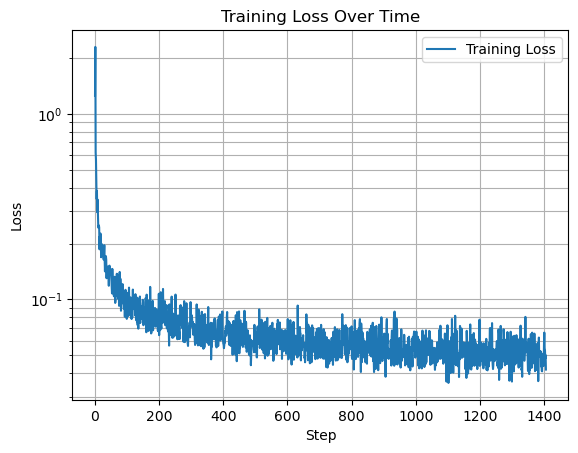

In [250]:
""" Create TimeConditionalUNet RF model and train it, or load weights from saved checkpoint. """

num_epochs = 3
num_hiddens = 64
batch_size = 128

load_from_saved = False
epoch_number_str = '2'
checkpoint_fname_stem = f'data/tcond_rf_epoch' # {epoch_number_str}.pth'
checkpoint_fname = f'{checkpoint_fname_stem}{epoch_number_str}.pth'

model = TimeConditionalUNet(
    in_channels=1,
    num_hiddens=num_hiddens,
).to(device)

rf = TCRF(
    unet=model,
    num_ts=300,
).to(device)

gamma = 0.1 ** (1.0 / num_epochs)

subset = torch.utils.data.Subset(train_set, list(range(10_000)))

dataloader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
)

optimizer = torch.optim.Adam(rf.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

cur_epoch = 0
tcond_rf_train_losses = []

if load_from_saved:

    checkpoint = torch.load(checkpoint_fname, weights_only=True)
    cur_epoch = checkpoint['epoch'] + 1
    tcond_rf_train_losses = checkpoint['train_losses']
    rf.load_state_dict(checkpoint['rf_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

for epoch in range(cur_epoch, num_epochs):
    epoch_loss = 0
    batch_count = 0
    for x, y in tqdm(dataloader):
        optimizer.zero_grad() ## .. i initially forgot this line and ended up with train curves that have a distincly oscillitory (underdamped) motion.. interesting..
        x = x.to(device)
        # x = x*2 - 1 ### affine scaling
        loss = rf(x)
        loss.backward()
        optimizer.step()
        tcond_rf_train_losses.append(loss.item())
        epoch_loss += loss.item()
        # batch_count += 1
        # if batch_count > 100:
        #     break
    average_loss = epoch_loss / len(dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

    lr_scheduler.step()

    if (epoch % 5 == 0) or (epoch == num_epochs - 1):
        checkpoint = {
            'epoch': epoch,
            'rf_state_dict': rf.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'train_losses': tcond_rf_train_losses,
        }
        path = f'{checkpoint_fname_stem}{epoch}.pth'
        # path = f'/content/drive/My Drive/cs180_project5/tcond_unet_optim_epoch{epoch}.pth'
        if not os.path.exists('data'):
            os.mkdir('data')

        torch.save(checkpoint, path)


%matplotlib inline
plt.plot(tcond_rf_train_losses, label='Training Loss')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid('true', which='both')
plt.title('Training Loss Over Time')
plt.legend()
# plt.savefig('/content/drive/My Drive/cs180_project5/tcond_ddpm_train_curve.png')
plt.show()

In [251]:
x_0, traj = rf.sample(img_wh=(28, 28), seed=345, num_samples=32)
inspect('x0', x_0)
show_tensor(torch.clip(x_0, 0, 1).cpu(), max_n_horiz=8, height=75)


x0:
shape: torch.Size([32, 1, 28, 28])
dtype: torch.float32
max: tensor(1.0531, device='mps:0')
min: tensor(-0.1440, device='mps:0')
mean: tensor(0.4231, device='mps:0')
std: tensor(0.4478, device='mps:0')

type im <class 'torch.Tensor'>


In [252]:
num_samples = 32


x = next(iter(DataLoader(dataset=torch.utils.data.Subset(train_set, list(range(num_samples))),
                                  batch_size=num_samples)))[0].to(device)
noise = torch.randn_like(x).to(device)

x_start = 0.5 * x + 0.5 * noise

inspect('xs', x_start)


# x_start = train_set[:num_samples]
x_0, traj = rf.sample(img_wh=(28, 28), seed=345, num_samples=num_samples, x_start=None)
show_tensor(torch.clip(x_0, 0, 1).cpu(), max_n_horiz=8, height=75)


xs:
shape: torch.Size([32, 1, 28, 28])
dtype: torch.float32
max: tensor(2.0594, device='mps:0')
min: tensor(-1.8533, device='mps:0')
mean: tensor(0.0623, device='mps:0')
std: tensor(0.5244, device='mps:0')

type im <class 'torch.Tensor'>


In [254]:
### load time conditional RF from checkpoint. create sample generation figures and animation

epoch_number_str = '2'
checkpoint_fname = f'data/tcond_rf_epoch{epoch_number_str}.pth'

model = TimeConditionalUNet(
    in_channels=1,
    num_hiddens=num_hiddens,
).to(device)

rf = TCRF(
    unet=model,
    num_ts=200,
).to(device)

checkpoint = torch.load(checkpoint_fname, weights_only=True)
rf.load_state_dict(checkpoint['rf_state_dict'])

n_samples = 32

x_0, traj = rf.sample(img_wh=(28, 28), seed=11, num_samples=n_samples)
inspect('x0', x_0)
inspect('traj', traj)
show_tensor(torch.clip(x_0, 0, 1).cpu(), max_n_horiz=8, height=75)

traj = traj.squeeze(2)
N, T, H, W = traj.shape
nrows = 4
assert (N % nrows) == 0, 'N must be divisible by nrows'
ncols = N // nrows
trj = (torch.clip(traj, 0, 1) * 255).byte().cpu().numpy()
# trj = trj.transpose(1, 2, 0, 3).reshape(T, H, -1)
trj = trj.reshape(nrows, ncols, T, H, W).transpose(2, 0, 3, 1, 4).reshape(T, nrows * H, ncols * W)

frames = [frame for frame in trj]

media.show_video(frames, height=200, fps=100)
# media.write_video(f'/content/drive/My Drive/cs180_project5/tcond_rf_sample_trajectories_epoch{epoch_number_str}.mp4', frames)





x0:
shape: torch.Size([32, 1, 28, 28])
dtype: torch.float32
max: tensor(1.0627, device='mps:0')
min: tensor(-0.1438, device='mps:0')
mean: tensor(0.3385, device='mps:0')
std: tensor(0.4254, device='mps:0')


traj:
shape: torch.Size([32, 200, 1, 28, 28])
dtype: torch.float32
max: tensor(4.8371, device='mps:0')
min: tensor(-4.7797, device='mps:0')
mean: tensor(0.0670, device='mps:0')
std: tensor(0.9458, device='mps:0')

type im <class 'torch.Tensor'>


In [171]:
torch.linspace(0, 1, 5)

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [172]:
list(range(5))

[0, 1, 2, 3, 4]

In [173]:
torch.randn(5, 1, 1).shape == (5, 1, 1)

True